<a href="https://colab.research.google.com/github/flediak/genIAL/blob/main/IA_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

This notebook shows how to model intrinsic galaxy alignment in a cosmoogical simulation using a modeling pipeline, based on the code genIAL. Once the IA simulation is generated, we compute two different alignment statistics

# 1) clone genIAL repository and import libraries

In [ ]:
! git clone https://github.com/flediak/genIAL.git

Cloning into 'genIAL'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 32 (delta 13), reused 9 (delta 3), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [ ]:
cd genIAL

/content/genIAL


In [ ]:
import pkg_resources
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from genial import Galaxy, IntrinsicAlignment

# 2) Download model input data

In [ ]:
! mkdir ../data/

### parameters for modeling galaxy 3D axis ratios

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1F6-XasMtdVk6BuR5TN8GnMc-AiUgu3Mf' -O ../data/ia_shape_parameters.csv

--2022-08-10 13:56:56--  https://docs.google.com/uc?export=download&id=1F6-XasMtdVk6BuR5TN8GnMc-AiUgu3Mf
Resolving docs.google.com (docs.google.com)... 74.125.20.100, 74.125.20.102, 74.125.20.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/usajc3tm32f2vbh2n45ks0j71o53khrb/1660139775000/07375493793059712153/*/1F6-XasMtdVk6BuR5TN8GnMc-AiUgu3Mf?e=download&uuid=4d791bab-3e02-41f3-bc86-025a3192c80b [following]
--2022-08-10 13:56:57--  https://doc-10-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/usajc3tm32f2vbh2n45ks0j71o53khrb/1660139775000/07375493793059712153/*/1F6-XasMtdVk6BuR5TN8GnMc-AiUgu3Mf?e=download&uuid=4d791bab-3e02-41f3-bc86-025a3192c80b
Resolving doc-10-5k-docs.googleusercontent.com (doc-10-5k-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e

### galaxy - halo catalogue

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CqboAhfDqNraH-V0WW3D7DX5ctMc17tl' -O ../data/input_file.parquet

--2022-08-10 13:56:59--  https://docs.google.com/uc?export=download&id=1CqboAhfDqNraH-V0WW3D7DX5ctMc17tl
Resolving docs.google.com (docs.google.com)... 74.125.20.100, 74.125.20.102, 74.125.20.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.20.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kq820lgmo7kbu2ethduv787nc951toaf/1660139775000/07375493793059712153/*/1CqboAhfDqNraH-V0WW3D7DX5ctMc17tl?e=download&uuid=40f0fbe4-1237-4973-8886-5cee800cb44a [following]
--2022-08-10 13:57:01--  https://doc-0c-5k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kq820lgmo7kbu2ethduv787nc951toaf/1660139775000/07375493793059712153/*/1CqboAhfDqNraH-V0WW3D7DX5ctMc17tl?e=download&uuid=40f0fbe4-1237-4973-8886-5cee800cb44a
Resolving doc-0c-5k-docs.googleusercontent.com (doc-0c-5k-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e

# 3) set model parameters

In [ ]:
# color cut
ia_ur_cut = 0.94

# read input table with shape model parameters
with open('../data/ia_shape_parameters.csv') as fd:
    ia_params = pd.read_csv(fd, header=0)
    ia_params.loc[ia_params['gal_color']==2.0, 'gal_color'] = Galaxy.Color.BLUE.value
    ia_params.loc[ia_params['gal_color']==0.0, 'gal_color'] = Galaxy.Color.RED.value
    ia_params = ia_params.set_index(['gal_color', 'z', 'mag']).sort_index()[['q_mean', 'r_mean', 'sigma']]

### instantiate IA class

In [ ]:
ia = IntrinsicAlignment(ia_params)

# 4) set up IA modeling pipeline

In [ ]:
def apply_ia(df_in, p_cb, p_sb, p_cr, p_sr, q_gal, s_gal, central_alignment):
    
    df = df_in.copy(deep=True)
    
    # assign random orientations to a,c,j for halos with zero component for all these vectors
    a_zero = (df['ax_halo']==0) & (df['ay_halo']==0) & (df['az_halo']==0)
    c_zero = (df['cx_halo']==0) & (df['cy_halo']==0) & (df['cz_halo']==0)
    j_zero = (df['jx_halo']==0) & (df['jy_halo']==0) & (df['jz_halo']==0)

    a_halo_rand = ia._random_vector(len(df.loc[a_zero|c_zero]))
    c_halo_rand = ia._random_perpendicular(a_halo_rand)
    j_halo_rand = ia._random_vector(len(df.loc[j_zero]))

    df.loc[a_zero,['ax_halo','ay_halo','az_halo']] = a_halo_rand.astype('f4')
    df.loc[a_zero,['cx_halo','cy_halo','cz_halo']] = c_halo_rand.astype('f4')
    df.loc[j_zero,['jx_halo','jy_halo','jz_halo']] = j_halo_rand.astype('f4')

    # use this color index for red blue definitions
    ia_ur = df['cfht_u_abs_mag'] - df['subaru_r_abs_mag']

    # define blue / red IDs
    ia_color = np.where(
        ia_ur < ia_ur_cut,
        Galaxy.Color.BLUE.value,
        Galaxy.Color.RED.value
    ).astype('i1')

    ### define satellite / central IDs
    ia_kind = np.where(
        cat.flag_central == 0,
        Galaxy.Kind.CENTRAL.value,
        Galaxy.Kind.SATELLITE.value
    ).astype('i1')

    #### make sure that vectors of major and minor axis and angular momentum are normalized
    df['a_halo'] = ((df['ax_halo']**2 + df['ay_halo']**2 + df['az_halo']**2)**0.5).astype('f4')
    df['c_halo'] = ((df['cx_halo']**2 + df['cy_halo']**2 + df['cz_halo']**2)**0.5).astype('f4')
    df['j_halo'] = ((df['jx_halo']**2 + df['jy_halo']**2 + df['jz_halo']**2)**0.5).astype('f4')

    df['ax_halo'] = (df['ax_halo'] / df['a_halo']).astype('f4')
    df['ay_halo'] = (df['ay_halo'] / df['a_halo']).astype('f4')
    df['az_halo'] = (df['az_halo'] / df['a_halo']).astype('f4')

    df['cx_halo'] = (df['cx_halo'] / df['c_halo']).astype('f4')
    df['cy_halo'] = (df['cy_halo'] / df['c_halo']).astype('f4')
    df['cz_halo'] = (df['cz_halo'] / df['c_halo']).astype('f4')

    df['jx_halo'] = (df['jx_halo'] / df['j_halo']).astype('f4')
    df['jy_halo'] = (df['jy_halo'] / df['j_halo']).astype('f4')
    df['jz_halo'] = (df['jz_halo'] / df['j_halo']).astype('f4')

    ### ====== set axis ratios ======
    # df['q_gal'], df['s_gal'] = ia.axis_ratio(ia_color, df['true_redshift_gal'].values, df['subaru_r_abs_mag'].values)
    df['q_gal'], df['s_gal'] = q_gal, s_gal

    df['q_gal'] = df['q_gal'].astype('f4')
    df['s_gal'] = df['s_gal'].astype('f4')


    ### ====== set orientations ======
    vg = np.array([
        df['x_gal'].values,
        df['y_gal'].values,
        df['z_gal'].values,
    ]).T
    vh = np.array([
        df['x_halo'].values,
        df['y_halo'].values,
        df['z_halo'].values,
    ]).T
    Ah = np.array([
        df['ax_halo'].values,
        df['ay_halo'].values,
        df['az_halo'].values,
    ]).T
    Ch = np.array([
        df['cx_halo'].values,
        df['cy_halo'].values,
        df['cz_halo'].values,
    ]).T
    Jh = np.array([
        df['jx_halo'].values,
        df['jy_halo'].values,
        df['jz_halo'].values,
    ]).T

    # set orientations for centrals and satellites
    Ag, Cg = ia.orientations(ia_kind, ia_color, vg, vh, Ah, Ch, Jh)


    # reset orientations for centrals for testing
    central = (ia_kind == Galaxy.Kind.CENTRAL)
    
    # option 1: same major and minor axis as host halo
    if central_alignment == 'PrincAx':
      Ag[central] = Ah[central]
      Cg[central] = Ch[central]

    # option 2: minor axis aligned with angular momentum vector, major axis random
    if central_alignment == 'AngMo':
        Ag[central] = ia._random_perpendicular(Jh[central])
        Cg[central] = Jh[central]


    df['ax_gal'] = Ag[:, 0].astype('f4')
    df['ay_gal'] = Ag[:, 1].astype('f4')
    df['az_gal'] = Ag[:, 2].astype('f4')
    df['cx_gal'] = Cg[:, 0].astype('f4')
    df['cy_gal'] = Cg[:, 1].astype('f4')
    df['cz_gal'] = Cg[:, 2].astype('f4')
   

    ### ====== randomize orientations ======
    df['sigma'] = ia.misalignment_parameters_v0(
        ia_kind, ia_color, df['subaru_r_abs_mag'].values.T, p_cr, p_cb, p_sr, p_sb
    ).astype('f4')

    Ar,Cr = ia.randomize(Ag, Cg, df['sigma'].values)

    df['ax_gal_rand'] = Ar[:, 0].astype('f4')
    df['ay_gal_rand'] = Ar[:, 1].astype('f4')
    df['az_gal_rand'] = Ar[:, 2].astype('f4')
    df['cx_gal_rand'] = Cr[:, 0].astype('f4')
    df['cy_gal_rand'] = Cr[:, 1].astype('f4')
    df['cz_gal_rand'] = Cr[:, 2].astype('f4')


    ### ====== get ellipticity ======
    vg = np.array([
        df['x_gal'].values,
        df['y_gal'].values,
        df['z_gal'].values,
    ]).T

    Ag = np.array([
        df['ax_gal_rand'].values,
        df['ay_gal_rand'].values,
        df['az_gal_rand'].values,
    ]).T

    Cg = np.array([
        df['cx_gal_rand'].values,
        df['cy_gal_rand'].values,
        df['cz_gal_rand'].values,
    ]).T

    qg = df['q_gal'].values.T
    sg = df['s_gal'].values.T

    df['eps1_gal'], df['eps2_gal'] = ia.ellipticity(vg, qg, sg, Ag, Cg)
    df['eps1_gal'] = df['eps1_gal'].astype('f4')
    df['eps2_gal'] = df['eps2_gal'].astype('f4')

    return df

# 5) model evaluation

### read input catalogue

In [ ]:
cat = pd.read_parquet('../data/input_file.parquet')#.iloc[0:1000]

### get angular coordinates (using MICECAT2 definition of ra and dec)
cat['r_gal'] = (cat.x_gal**2 + cat.y_gal**2 + cat.z_gal**2)**0.5
cat['ra_gal'] = np.arctan2(cat.x_gal,cat.y_gal)*180/np.pi
cat['dec_gal'] = np.arcsin(cat.z_gal/cat.r_gal)*180/np.pi

print(len(cat))

NameError: ignored

### set values for galaxy 3D axis ratios

In [ ]:
q_gal, s_gal = 1.0, 0.2

### make catalogs with low misalgnment

In [ ]:
# blue centrals and satellites
p_cb, p_sb = [0.1, 0.0],  [0.1, 0.0]
# red centrals and satellites
p_cr, p_sr = [0.1, 0.0], [0.1, 0.0]

central_alignment = 'PrincAx'
catA = apply_ia(cat, p_cb, p_sb, p_cr, p_sr, q_gal, s_gal, central_alignment)

central_alignment = 'AngMo'
catB = apply_ia(cat, p_cb, p_sb, p_cr, p_sr, q_gal, s_gal, central_alignment)

### make catalogs with high misalignment

In [ ]:
# blue centrals and satellites
p_cb, p_sb = [0.5, 0.0],  [0.5, 0.0]
# red centrals and satellites
p_cr, p_sr = [0.5, 0,0], [0.5, 0.0]

central_alignment = 'PrincAx'
catC = apply_ia(cat, p_cb, p_sb, p_cr, p_sr, q_gal, s_gal, central_alignment)

central_alignment = 'AngMo'
catD = apply_ia(cat, p_cb, p_sb, p_cr, p_sr, q_gal, s_gal, central_alignment)

# 6) compute 3D alignment statistics

### install covo

In [ ]:
cd ..

/content


In [ ]:
! git clone https://flediak@bitbucket.org/flediak/covo.git

Cloning into 'covo'...
Receiving objects: 100% (369/369), 13.85 MiB | 15.92 MiB/s, done.
Resolving deltas: 100% (220/220), done.


In [ ]:
cd covo/src

/content/covo/src


In [ ]:
! make

g++ -c main.cpp -std=c++11 -O3
g++ -c parameters.cpp -std=c++11 -O3
g++ -c directory.cpp -std=c++11 -O3
g++ -c healpix.cpp -std=c++11 -O3
g++ -c catalogue.cpp -std=c++11 -O3
g++ -c correlation.cpp -std=c++11 -O3
g++ -o ../covo main.o parameters.o directory.o healpix.o catalogue.o  correlation.o


In [ ]:
cd ..

/content/covo


In [ ]:
! mkdir results

### run measurements

In [ ]:
def get_3Dstats(df):
    
    # write input files
    fname_cat_shape = 'catalogues/ia_cat_shape.csv'
    fname_cat_dense = 'catalogues/ia_cat_dense.csv'

    columns_shape = ['x_gal', 'y_gal', 'z_gal', 'ax_gal_rand', 'ay_gal_rand', 'az_gal_rand', 'cx_gal_rand', 'cy_gal_rand', 'cz_gal_rand']
    columns_dense = ['x_gal', 'y_gal', 'z_gal']

    df[columns_shape].to_csv(fname_cat_shape, index=None, header=None, compression=None, sep=",")
    df[columns_dense].to_csv(fname_cat_dense, index=None, header=None, compression=None, sep=",")

    # run covo
    ! ./covo covo.params_lightcone catalogues/ia_cat_shape.csv catalogues/ia_cat_dense.csv results/eta.csv

    # read results
    eta = pd.read_csv('./results/eta.csv')

    return eta

In [ ]:
etaA = get_3Dstats(catA)
etaB = get_3Dstats(catB)
etaC = get_3Dstats(catC)
etaD = get_3Dstats(catD)


# ================ PARAMETERS ================
# fname_cat_1: catalogues/ia_cat_shape.csv
# fname_cat_2: catalogues/ia_cat_dense.csv
# fname_out: input
# delim_in: ,
# delim_out: ,
# header_out: 1

# mode: shell
# auto_limits: 1
# nside: 8
# nrad: 2

# columns in input catalogue: 
# - position vector: 0 1 2 
# - vector a: 3 4 5 
# - vector b: 6 7 8 

# r_min = 0.1
# r_max = 40
# numb_bin = 20
# lg_bins = 1

# expip = 1

# r12_v1a = 1
# r12_v1b = 1
# r12_v2a = 0
# r12_v2b = 0
# v1a_v2a = 0
# v1b_v2b = 0
# v1a_v2b = 0
# v1b_v2a = 0

# make_rand = 0
# ============================================


# ==== read data ====
# size of catalogue 1: 229131

# size of catalogue 2: 229131

# min. / max. coordinates in catalogue 1
# 215.658 < r < 575.975
# 0.0802959 < theta < 90
# 0.00128311 < phi < 89.9944

# min. / max. coordinates in catalogue 2
# 215.658 < r < 575.975
# 0.0802959 < theta < 90
# 0.00128311 < phi < 89.9944

# cut out overlap region between cat 1 and cat 2

# make subsamples
# num

### plot results

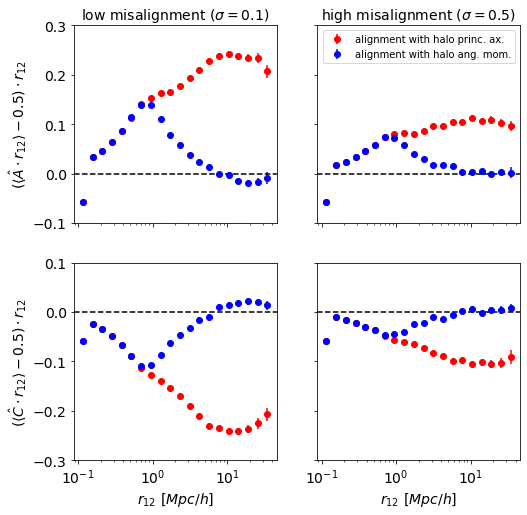

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(8,8), sharex=True, sharey='row')

fontsize = 14


label1 = 'alignment with halo princ. ax.'
label2 = 'alignment with halo ang. mom.'

#==== low misalignment ======
ix = 0
ax[0,ix].set_title('low misalignment ($\sigma=0.1$)', fontsize=fontsize)

eta = etaA
ax[0,ix].errorbar(eta.r, (eta.r12_v1a-0.5)*eta.r, eta.r12_v1a_std*eta.r, c='r', marker='o', ls='')
ax[1,ix].errorbar(eta.r, (eta.r12_v1b-0.5)*eta.r, eta.r12_v1b_std*eta.r, c='r', marker='o', ls='')

eta = etaB
ax[0,ix].errorbar(eta.r, (eta.r12_v1a-0.5)*eta.r, eta.r12_v1a_std*eta.r, c='b', marker='o', ls='')
ax[1,ix].errorbar(eta.r, (eta.r12_v1b-0.5)*eta.r, eta.r12_v1b_std*eta.r, c='b', marker='o', ls='')


#==== high misalignment ======
ix = 1
ax[0,ix].set_title('high misalignment ($\sigma=0.5$)', fontsize=fontsize)

eta = etaC
ax[0,ix].errorbar(eta.r, (eta.r12_v1a-0.5)*eta.r, eta.r12_v1a_std*eta.r, c='r', marker='o', ls='', label=label1)
ax[1,ix].errorbar(eta.r, (eta.r12_v1b-0.5)*eta.r, eta.r12_v1b_std*eta.r, c='r', marker='o', ls='')

eta = etaD
ax[0,ix].errorbar(eta.r, (eta.r12_v1a-0.5)*eta.r, eta.r12_v1a_std*eta.r, c='b', marker='o', ls='', label=label2)
ax[1,ix].errorbar(eta.r, (eta.r12_v1b-0.5)*eta.r, eta.r12_v1b_std*eta.r, c='b', marker='o', ls='')


#==== cosmetics =====
ax[0,1].legend(fontsize=10)

for ix in range(2):
  ax[-1,ix].set_xlabel('$r_{12} \ [Mpc/h]$', fontsize = fontsize)

ax[0,0].set_ylabel(r'($\langle \hat{A} \cdot r_{12} \rangle - 0.5) \cdot r_{12} $',fontsize=fontsize)
ax[1,0].set_ylabel(r'($\langle \hat{C} \cdot  r_{12} \rangle - 0.5) \cdot r_{12} $ ',fontsize=fontsize)
    
for ix in range(2):
    ax[0,ix].set_ylim(-0.1,0.3)
    ax[1,ix].set_ylim(-0.3,0.1)

for ix in range(2):
    for iy in range(2):
        ax[iy, ix].set_xscale('log')
        ax[iy, ix].tick_params(axis='both',labelsize=fontsize)
        ax[iy, ix].axhline(y=0.0, c='k', linestyle='--')

# 7) compute wg+

### make random catalogue

In [ ]:
from scipy import interpolate

In [ ]:
def make_random(r_gal, Nrand, L_tophat = 20):
    
    ##### random distances #####
    
    # galaxy counts in radial bins
    counts, bin_edges = np.histogram(r_gal, bins=1000)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])*0.5
    bin_width = bin_edges[1]-bin_edges[0]

    if L_tophat< bin_width:
        print('error: tophat filter must be larger than', bin_width)
        return 1
    
    # define tophat filter for smoothing nofr
    nbins_tophat = int(L_tophat/bin_width)
    tophat_filter = np.ones(nbins_tophat)

    counts_snooth = np.convolve(counts, tophat_filter, mode='same')/(nbins_tophat)

    #cut edges of distribution by size of tophat filter to avoid boundary effects
    counts_snooth = counts_snooth[nbins_tophat:-nbins_tophat]
    bin_centers_smooth = bin_centers[nbins_tophat:-nbins_tophat]
    
    # random distances from inverse transform sampling
    cdf = np.cumsum(counts_snooth)
    cdf = cdf/cdf.max()
    inv_cdf = interpolate.interp1d(cdf,bin_centers_smooth)

    rnd = np.random.rand(Nrand)*(cdf.max()-cdf.min())+cdf.min()
    r_rand = inv_cdf(rnd)
    
    
    ##### random angles #####
    # in MICE coordinates: ra = atan(x/y), dec = asin(z/r)
    
    f = np.pi/180.
    ra_min, ra_max = 0,90
    dec_min, dec_max = 0,90

    ra_rand = np.random.uniform(ra_min, ra_max, Nrand)
    cos_dec = np.random.uniform(np.cos(dec_min*f), np.cos(dec_max*f),Nrand)
    dec_rand = 90-np.arccos(cos_dec)/f
    
    
    return r_rand, ra_rand, dec_rand
    

In [ ]:
L_tophat = 20# size of tophat filter for nofr in same units as simulation coordinates
Nrand = len(cat)*2 # number of points in random catalog

r_gal = (cat.x_gal**2 + cat.y_gal**2 + cat.z_gal**2)**0.5

r_rand, ra_rand, dec_rand = make_random(r_gal, Nrand, L_tophat)

# put random catalogue in pandas datafrane
cat_random = pd.DataFrame(data=np.array([r_rand, ra_rand, dec_rand]).T, columns=['ra_gal','dec_gal','r_gal'])

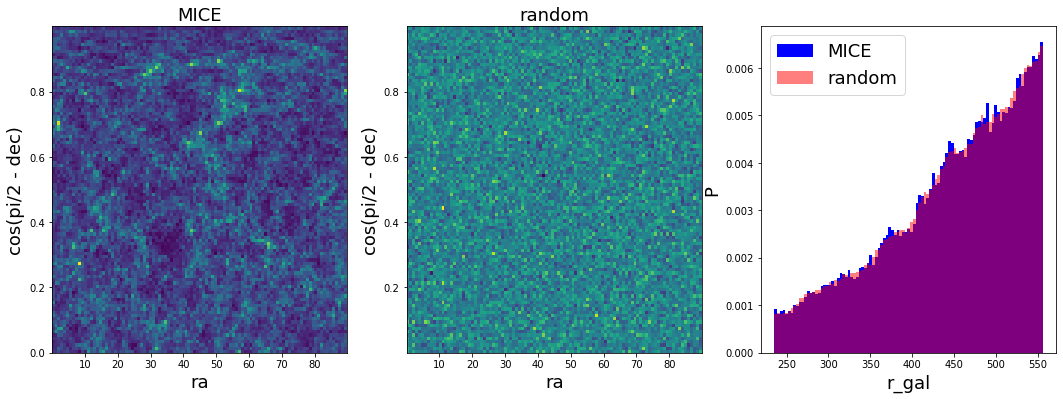

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(18,6))

f = np.pi/180.
    
fontsize=18
    
#======== ra, dec distibution ========
dec = np.arcsin(cat.z_gal/r_gal)/f
ra = np.arctan(cat.x_gal/cat.y_gal)/f
ax[0].hist2d(ra, np.cos(np.pi/2 - dec*f), bins=100)
ax[1].hist2d(ra_rand, np.cos(np.pi/2 - dec_rand*f), bins=100)
#ax[0].hist2d(ra, dec*f, bins=100)
#ax[1].hist2d(ra_rand, dec_rand, bins=100)

ax[0].set_title('MICE', fontsize=fontsize)
ax[1].set_title('random', fontsize=fontsize)

for ix in range(2):
    ax[ix].set_xlabel('ra', fontsize=fontsize)
    ax[ix].set_ylabel('cos(pi/2 - dec)',fontsize=fontsize)    
    #ax[ix].set_ylabel('dec',fontsize=fontsize)

#======= radial distribution =======
rbins = np.linspace(r_rand.min(), r_rand.max(), 100)
ax[2].hist(r_gal, bins=rbins, density=True, color='b', label='MICE')
ax[2].hist(r_rand, bins=rbins, density=True, color='r', alpha=0.5, label='random')
ax[2].set_xlabel('r_gal', fontsize=fontsize)
ax[2].set_ylabel('P', fontsize=fontsize)
ax[2].legend(fontsize=fontsize)

plt.show()

In [ ]:
# randial range of random catalogue is reduced by size of smoothing window
# -> cut radial range of galaxy catalogue to the range covered by the random

catA = catA.loc[(r_rand.min() <=r_gal) &  (r_gal <= r_rand.max())]
catB = catB.loc[(r_rand.min() <=r_gal) &  (r_gal <= r_rand.max())]
catC = catC.loc[(r_rand.min() <=r_gal) &  (r_gal <= r_rand.max())]
catD = catD.loc[(r_rand.min() <=r_gal) &  (r_gal <= r_rand.max())]

### call treecorr

In [ ]:
!pip install treecorr
import treecorr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.8 MB 7.4 MB/s 


In [ ]:
def compute_xi_gp_2d(cat_rcut, randoms, npi, nbins, slop):
    
  # arrays to store the output
  r     = np.zeros((npi,nbins))
  SpD_xi   = np.zeros_like(r)
  SpR_xi   = np.zeros_like(r)
  RR_pairs   = np.zeros_like(r)  

  positionsdata = cat_rcut
  shapesdata = cat_rcut
  positionsrand = randoms
  shapesrand = randoms
    
  # catalogues
  pcat  = treecorr.Catalog(g1=None, g2=None, ra=positionsdata['ra_gal'], dec=positionsdata['dec_gal'], r=positionsdata['r_gal'], ra_units='deg', dec_units='deg')
  scat  = treecorr.Catalog(g1=-shapesdata['eps1_gal'], g2=-shapesdata['eps2_gal'], ra=shapesdata['ra_gal'], dec=shapesdata['dec_gal'], r=shapesdata['r_gal'], ra_units='deg', dec_units='deg')
  rpcat = treecorr.Catalog(g1=None, g2=None, ra=positionsrand['ra_gal'], dec=positionsrand['dec_gal'], r=positionsrand['r_gal'], ra_units='deg', dec_units='deg')
  rscat = treecorr.Catalog(g1=None, g2=None, ra=shapesrand['ra_gal'], dec=shapesrand['dec_gal'], r=shapesrand['r_gal'], ra_units='deg', dec_units='deg')
    
  # get pair-normalisation factors = total sum of (non-duplicate) weighted pairs with unlimited separation
  NGtot = 1.*pcat.sumw*scat.sumw
  RRtot = 1.*rpcat.sumw*rscat.sumw
  RGtot = 1.*rpcat.sumw*scat.sumw
    
  f0 = RRtot / NGtot
  f1 = RRtot / RGtot

  Pi = np.array([-233,-144,-89,-55,-34,-21,-13,-8,-5,-3,-2,-1,0,1,2,3,5,8,13,21,34,55,89,144,233])
    
  pibins = zip(Pi[:-1],Pi[1:])
    
  # now loop over Pi bins, and compute w(r_p | Pi)
  for p,(plow,phigh) in enumerate(pibins):    
    rr = treecorr.NNCorrelation(nbins=5, min_sep=0.1, max_sep=18, min_rpar=plow, max_rpar=phigh, bin_slop=slop, verbose=0)
    ng = treecorr.NGCorrelation(nbins=5, min_sep=0.1, max_sep=18, min_rpar=plow, max_rpar=phigh, bin_slop=slop, brute = False, verbose=0)
    rg = treecorr.NGCorrelation(nbins=5, min_sep=0.1, max_sep=18, min_rpar=plow, max_rpar=phigh, bin_slop=slop, brute = False, verbose=0)                 
        
    ng.process_cross(pcat, scat, metric='Rperp') #It processes a galaxy-intrinsic shear correlation between the shapes and the position catalogs      
    SpD_xi[p,:] = np.copy(ng.xi)
    ng.clear()
        
    rg.process_cross(rpcat, scat, metric='Rperp') #It processes a galaxy-intrinsic shear correlation between a random catalog and the shapes catalogs
    SpR_xi[p,:] = np.copy(rg.xi)
    rg.clear()   

    rr.process_cross(rpcat, rscat, metric='Rperp')
    r[p,:] = np.copy(rr.rnom)
    RR_pairs[p,:] = rr.weight
    rr.clear()
        
  xi_gp = ((f0*SpD_xi) - (f1*SpR_xi)) / RR_pairs #It computes xi_gp using the normalisation factors 
  xi_gp[np.isinf(xi_gp)] = 0. #It sets to 0 the values of xi_gp that are infinite
  xi_gp[np.isnan(xi_gp)] = 0. #It sets to 0 the values of xi_gp that are null    

  xPi=(Pi[:-1]+Pi[1:])/2 #It returns an array going from -9.5,-8.5,...,8.5,9.5

  return r, xPi, xi_gp

In [ ]:
r, Pi, xi_gp = compute_xi_gp_2d(catA, cat_random, npi=24, nbins=5, slop=0.)
wgp_catA = np.trapz(xi_gp,Pi,axis=0) #It integrates xi_gp using the trapezoidal rule using xPi (Pi) as dx

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
wgp_catA

array([ 1.16495046e-01,  7.77839346e-02, -2.42011795e-01, -1.03618270e+05,
       -3.30170408e+04])

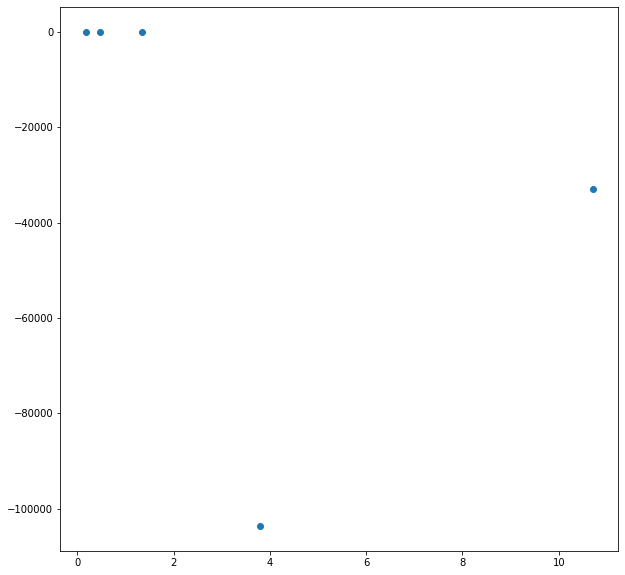

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

ax.scatter(r[0], wgp_catA, label=r'$w_{gg}$')
#ax2.plot(r[0], (r[0]**0.8)*wgp, markersize = 4, label=r'$w_{gp}$')
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax1.legend(loc='lower left')
#ax1.set_xlabel('$r_p$ [$h^{-1}$ Mpc]')
#ax1.set_ylabel(r'$ w_{gg}$ [$h^{-1}$ Mpc]')
#ax1.set_title('Clustering')
#ax2.set_xscale('log')
#ax2.legend(loc='lower left')
#ax2.set_xlabel('$r_p$ [$h^{-1}$ Mpc]')
#ax2.set_ylabel(r'$r_p^{0.8} w_{g+}$ [$h^{-1}$ Mpc]$^{1.8}$')
#ax2.set_title('Alignments') 